## Projeto para detecção de vendedores que podem deixar da base da Olist.

### Etapa 3/5 Processamento, Exploração dos dados e Construção do modelo

Após a geração da ABT(*Analytical Base Table*) utilizando o programa *geracao_abt.py*. Podemos dar o próximo passo com o objetivo de modelar um algoritmo.
Estarei realizando a Análise Exploratória de Dados e em seguida verificando qual algoritmo será otimizado para com o intuito de separar os vendores com base na probabilidade de não realizar vendas. 

Caso queira executar este Notebook certifique-se que:
* O banco de dados esteja na pasta Data;
* A tabela *tb_abt_no_sells* esteja devidamente criada e populada, caso contrário rodar o programa *geração_abt.py*;
* Todas as bibliotecas estejam instaladas (lista com as bibliotecas estão salvas no repositório *requirements.txt*).

Este Notebook tem como objetivo analisar e otimizar o Dataset para a definição de um algoritmo de Machine Learning que será salvo em um arquivo Pickle.

In [1]:
#Importando bibliotecas
import os 
import sqlalchemy
import numpy as np
import pandas as pd

# Visualização
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Criaçao de Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Pre processamento
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Metodos e Modelos 
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, RandomizedSearchCV, GridSearchCV

# Algormitmos de ML
from sklearn import tree, ensemble, svm, neighbors, linear_model, naive_bayes
import lightgbm as lgb

# Métricas
from sklearn.metrics import classification_report, precision_recall_curve, auc

# Outras Configurações
pd.set_option('display.max_columns',100)

## Carregando a ABT

A ABT se encontra na tabela **tb_abt_no_sells**

In [2]:
# Carregando os paths do banco de dados
dir_local = os.path.dirname(os.path.abspath('__file__'))
dir_project = os.path.dirname(dir_local)
dir_db = os.path.join(dir_project,'Data/olist.db')
# Efetuando a conexão com o SQLAlchemy e carregando o Dataset
con = sqlalchemy.create_engine('sqlite:///'+ dir_db)
load_abt_churn = "SELECT * from tb_abt_no_sells"
dataset = pd.read_sql(load_abt_churn , con)

## Conhecendo o Dataset


O Dataset possui 17015 linhas e 25 Colunas e os tipos de dados se distribuem da seguinte forma

|Tipo de Variável | Tipo | Qtde. | 
|-------- | -----| -----|
|Quantitativa| Continua | 13 |
|Quantitativa| Discretas | 9 |
|Qualitativa| Qualtativa | 3 |
|Qualitativa| Ordinal | 0 |

Existem 2 variáveis que possuem dados nulos que deverão ser tratadas posteriormente

In [3]:
dataset.head()

,flag_venda,data_lim_safra,seller_id,estado,idade_dias,qtde_vendas,variedade_prod,qtde_prod_vendidos,media_prod_vend_order,media_fotos,media_letras_desc,avaliacao_safra,avaliacao_acumulada,delta_avaliacao_idade_base,ultima_venda,qtde_mes_ativos,prop_atrasos,media_prazo_entrega,receita_total,ticket_medio,valor_medio_prod,total_mensal,frete_medio,prop_valor_frete,intervalo_pedidos_dias
0,1,2017-04-01,001cca7ae9ae17fb1caed9dfb1094831,ES,55,16,3,28,1.750000,2.928571,497.642857,3.571429,3.571429,-0.0,0,2,0.035714,26,2775.60,173.47500,99.128571,1387.800000,40.237500,0.231950,3
1,1,2017-04-01,004c9cd9d87a3c30c522c48c4fc07416,SP,62,23,23,30,1.304348,1.206897,628.413793,4.533333,4.533333,-0.0,11,3,0.033333,27,3818.21,166.00913,127.273667,1272.736667,22.273043,0.134168,2
2,0,2017-04-01,00ab3eff1b5192e5f1a63bcecfee11c8,SP,13,1,1,1,1.000000,1.000000,646.000000,5.000000,5.000000,0.0,13,1,0.000000,18,98.00,98.00000,98.000000,98.000000,12.080000,0.123265,13
3,0,2017-04-01,011b0eaba87386a2ae96a7d32bb531d1,SP,175,1,1,2,2.000000,1.000000,1212.000000,4.000000,4.000000,0.0,175,1,0.000000,53,99.98,99.98000,49.990000,99.980000,29.180000,0.291858,175
4,0,2017-04-01,013900e863eace745d3ec7614cab5b1a,PR,27,2,2,2,1.000000,5.500000,883.000000,5.000000,5.000000,0.0,4,1,0.000000,27,146.00,73.00000,73.000000,146.000000,20.160000,0.276164,13


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17015 entries, 0 to 17014
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   flag_venda                  17015 non-null  object 
 1   data_lim_safra              17015 non-null  object 
 2   seller_id                   17015 non-null  object 
 3   estado                      17015 non-null  object 
 4   idade_dias                  17015 non-null  int64  
 5   qtde_vendas                 17015 non-null  int64  
 6   variedade_prod              17015 non-null  int64  
 7   qtde_prod_vendidos          17015 non-null  int64  
 8   media_prod_vend_order       17015 non-null  float64
 9   media_fotos                 16595 non-null  float64
 10  media_letras_desc           16595 non-null  float64
 11  avaliacao_safra             17015 non-null  float64
 12  avaliacao_acumulada         17015 non-null  float64
 13  delta_avaliacao_idade_base  170

In [5]:
dataset.shape

(17015, 25)

## Separando uma parte do dataset para Out of Time (OOT)
Nesse caso será separada a **última safra** para OOT as restantes serão utilizadas para o desenvolvimento do algoritmo.  
Esta parecela do dataset será utilizada para validação ao fim do processo.

In [6]:
safras = dataset['data_lim_safra'].unique()
safras_oot = safras[-1:] # Separando a data da última safra

#Invertendo a Variável target para: 0 Vendeu nos próximos 3 meses e 1 para não vendeu
dataset['flag_venda'] = dataset['flag_venda'].astype(int)
dataset['flag_n_venda'] = dataset['flag_venda'].replace({0:1, 1:0})
dataset.drop(columns='flag_venda' , inplace= True)

dataset['estado'] = dataset['estado'].astype('category')
df_oot = dataset[ dataset['data_lim_safra'] >= safras_oot[0]].copy() # dataset de validação
df = dataset[ dataset['data_lim_safra'] < safras_oot[0]].copy() # dataset para desenvolvimento

print(f"Safra separada para Tratamento : {df['data_lim_safra'].unique()}")
print(f"Safra separada para Out Of Time : {df_oot['data_lim_safra'].unique()}")


Safra separada para Tratamento : ['2017-04-01' '2017-05-01' '2017-06-01' '2017-07-01' '2017-08-01'
 '2017-09-01' '2017-10-01' '2017-11-01' '2017-12-01' '2018-01-01'
 '2018-02-01' '2018-03-01' '2018-04-01']
Safra separada para Out Of Time : ['2018-05-01']


## Manipulando e separando as Features para o início dos trabalhos
Como algumas colunas não deverão ser utilizadas para o treino as mesmas serão excluidas

In [7]:
# Separando as colunas de features e target e separando os dados entre treino e teste
df_columns = df.columns.to_list()
to_remove = ['flag_venda', 'data_lim_safra', 'seller_id', 'flag_n_venda']
target = 'flag_n_venda'
features = [i for i in df_columns if i not in to_remove]

## Análise Exploratória dos dados

Para a análise dos dados estou utilizando o Sweet Viz como ferramenta e para verificar os gráficos o mesmo esta salvo como Analise Exploratória.html nesta mesma pasta
* Flag Venda = possui dados desbalanceado (69%/31%)  
* Data Limite Safra = Demonstra um crescimento na quantidade de vendas já que são apenas computadas as vendas que foram realmente efetivadas,  
* Estado = Demonstra uma predominancia dos vendedores residentes no estado de SP seguido do PR
* Idade Dias = Pode-se observar que a maioria dos usuários possui menos de 5 meses na plataforma
* Qtde de Vendas  = 21.1% deste dataset com vendedores com apenas uma venda, ***
* Variedade de Produtos = Mais de 50% do do dataset possui 3 produtos como variedade vendidas
* Ticket Médio = Verificando os valores altos de Ticket médio curiosamente localizei um potencial vendedor fraudador da plataforma onde possuia um Ticket médio alto mas péssimas avaliaçoes, resolvi ir um pouco a fundo e realmente parecia muito suspeito. Como não é o proposito deste projeto detectar fraudador e o mesmo irá fornecer dados não condizentes com a realidade de vendas, resolvi tirar estes dados do dataset
* Ao verificar a correlação das variáveis houve 3 casos de variaveis com uma alta correlação sendo assim resolvi excluir 2 variáveis Qtde de Vendas e Avaliação Acumulada, o ultimo caso resolvi manter ambas as variáveis (Ticket médio e Valor Médio do Produto), pois caso os clientes comprem diversas quantidades essa variável irá se alterar.


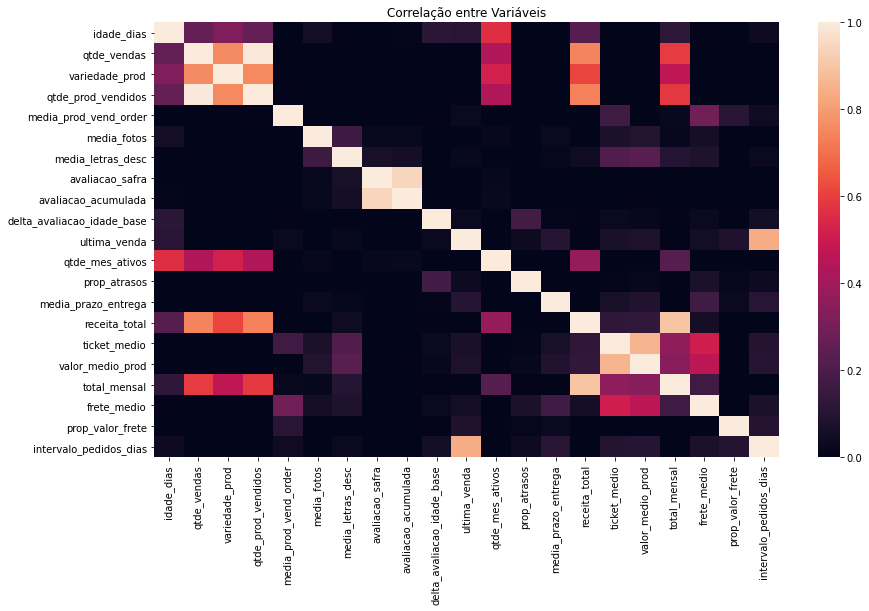

In [8]:
#Carregando o relatório através do SweetViz
#Em 2 colunas foram encontrados 2% do dataset com valores nulos Média de fotos e Média letras descrição.
# Distribuição destes dados se mostra Assimétrica Positiva e estarei substituindo estes valores pela mediana posteriormente.
#report = sv.analyze(df)
#report.show_html(filepath='Analise_Exploratoria.html')



# Sei que o SweetViz fornece tambem uma visualização correlação porém prefiro a do Seaborn
plt.figure(figsize = (14, 8))
correlation = df[features].corr(method = 'pearson')
plt.title("Correlação entre Variáveis")
ax = sns.heatmap(correlation, vmin=0, vmax=1)

In [9]:
# Retirando da base o Vendedor com grandes chances de ser um fraudador
sellers_fraude = df.query('ticket_medio>1500 and avaliacao_safra < 2')['seller_id'].unique().tolist() #Localizando o Vendedor que pode ser um fraudador
df = df.query('seller_id not in @sellers_fraude') # Retirando o possível usuário fraudador

# Variaveis com correlacoes altas
corr_alta = ['qtde_vendas','avaliacao_acumulada']
features = [i for i in features if i not in corr_alta] # Removendo as 2 variáveis

## Preparação e definição do Pipeline que realizará pré processamento

Definida a estratégia para reposição dos dados nulos, os dados irão ser separados em variaváveis numéricas e categóricas.
Existe apenas uma coluna com variaveis categoricas 'estado', como a mesma se trata de uma variável nominal, portanto não há necessidade de realizar um tratamento de variaveis categoricas ordinais neste dataset.  
Para as variáveis numéricas será aplicado o Simple Imputer substituindo os valores pela mediana e posteriormente aplicando o MinMax Scaler para o pre-processamento.
Para as variáveis categóricas será aplicado o One Hot Encoder


In [10]:
# Separando as features entre categóricas e numéricas
cat_features = df[features].dtypes[df[features].dtypes == 'category'].index.tolist()
num_features = df[features].dtypes[df[features].dtypes !='category'].index.tolist()

num_enc = Pipeline([('imputer' , SimpleImputer(missing_values= np.nan , strategy='median')),
                    ('scaler', MinMaxScaler())])
preparation = ColumnTransformer( transformers= [    ('numeric', num_enc, num_features),
                                                    ('categorical' , OneHotEncoder(handle_unknown = 'ignore'), cat_features)])

## Validação Cruzada

### Validação Cruzada com os Algoritmos a serem usados nas Pipelines
Selecionando alguns algoritmos para verificar os resultados de cada um deles. Estarei utilizando a métricas de ROC AUC Score como base neste Validação cruzada.  
OBS1: Como alguns algoritmos apresentaram overfit já apliquei algumas medidas para evitar o overfit das mesmas.  
OBS2: Como são testados diversos algoritmos ao mesmo tempo nesta etapa estarei aplicando o mesmo pipeline de preparacao dos dados, compreendo que alguns não necessitam de certos pre processamentos porém é apenas uma baseline para a escolha do algoritmo.

In [11]:
#Definição dos Algoritmos de Machine Learning
algoritmos = [ 
                # Tree
                tree.DecisionTreeClassifier(min_samples_leaf = 0.01 ), #evitando o overfit
                tree.ExtraTreeClassifier(min_samples_leaf = 0.01),#evitando o overfit
                # SVM
                svm.LinearSVC(),
                # Neighbors
                neighbors.KNeighborsClassifier(n_neighbors=15),
                # Naive Bayes
                naive_bayes.BernoulliNB(),
                naive_bayes.GaussianNB(),
                # GLM
                linear_model.LogisticRegression(),
                linear_model.RidgeClassifier(),
                linear_model.SGDClassifier(),
                linear_model.Perceptron(),
                # Ensemble Methods
                ensemble.AdaBoostClassifier(),
                ensemble.GradientBoostingClassifier(),
                ensemble.ExtraTreesClassifier(min_samples_leaf = 0.02),#evitando o overfit
                ensemble.RandomForestClassifier(min_samples_leaf = 0.02),#evitando o overfit
                lgb.LGBMClassifier(is_unbalance=True, num_leaves=8)
                ]

#Criando um Dataframe com os resultados assim pode-se comparar os resultados

MLA_cols = ["MLA Name", "MLA Parameters", "MLA Train F1score Mean", "MLA Test F1score Mean", "MLA Test F1score DV Pad", "MLA Time"]
MLA_Compare = pd.DataFrame(columns=MLA_cols)
row_index = 0 # set index

# A métrica utilizada para escolha do melhor algoritmo será a ROC AUC

cv_split = ShuffleSplit(random_state=123)
for algoritmo in algoritmos:
    pipe_loop = Pipeline([  ('prep' , preparation),
                            ('alg' , algoritmo)])
    MLA_name = pipe_loop['alg'].__class__.__name__  
    print(f"Processando o algoritmo {MLA_name}") 
    MLA_Compare.loc[row_index,"MLA Name"]  = MLA_name
    MLA_Compare.loc[row_index, "MLA Parameters"] = str(pipe_loop['alg'].get_params())
    cv_results = cross_validate(pipe_loop, X= df[features], y= df[target], cv= cv_split, return_train_score=True, n_jobs=-1 , scoring='f1')
    #Resultados da validação cruzada
    MLA_Compare.loc[row_index, "MLA Time"] = cv_results['fit_time'].mean()
    MLA_Compare.loc[row_index, "MLA Train F1score Mean"] = cv_results['train_score'].mean()
    MLA_Compare.loc[row_index, "MLA Test F1score Mean"] = cv_results['test_score'].mean()
    MLA_Compare.loc[row_index, "MLA Test F1score DV Pad"] = cv_results['test_score'].std()*3
    row_index +=1

MLA_Compare.sort_values(by="MLA Test F1score Mean", ascending=False, inplace=True , ignore_index=True)

Processando o algoritmo DecisionTreeClassifier
Processando o algoritmo ExtraTreeClassifier
Processando o algoritmo LinearSVC
Processando o algoritmo KNeighborsClassifier
Processando o algoritmo BernoulliNB
Processando o algoritmo GaussianNB
Processando o algoritmo LogisticRegression
Processando o algoritmo RidgeClassifier
Processando o algoritmo SGDClassifier
Processando o algoritmo Perceptron
Processando o algoritmo AdaBoostClassifier
Processando o algoritmo GradientBoostingClassifier
Processando o algoritmo ExtraTreesClassifier
Processando o algoritmo RandomForestClassifier
Processando o algoritmo LGBMClassifier


### Resultados da Validação Cruzada
Como esperado os melhores resultados vieram de algoritmos ensembles, o algoritmo de **Light GBM** como padrão utiliza o metodo de Gradient Boosting Decision Trees com algumas diferenças do Gradient Boosting em outros parametros.
Como o tempo de processamento para otimizar os parametros do Light GBM é relativamente mais rápido e os resultados em uma baseline foram melhores, estarei utilizando ele para as proximas etapas.

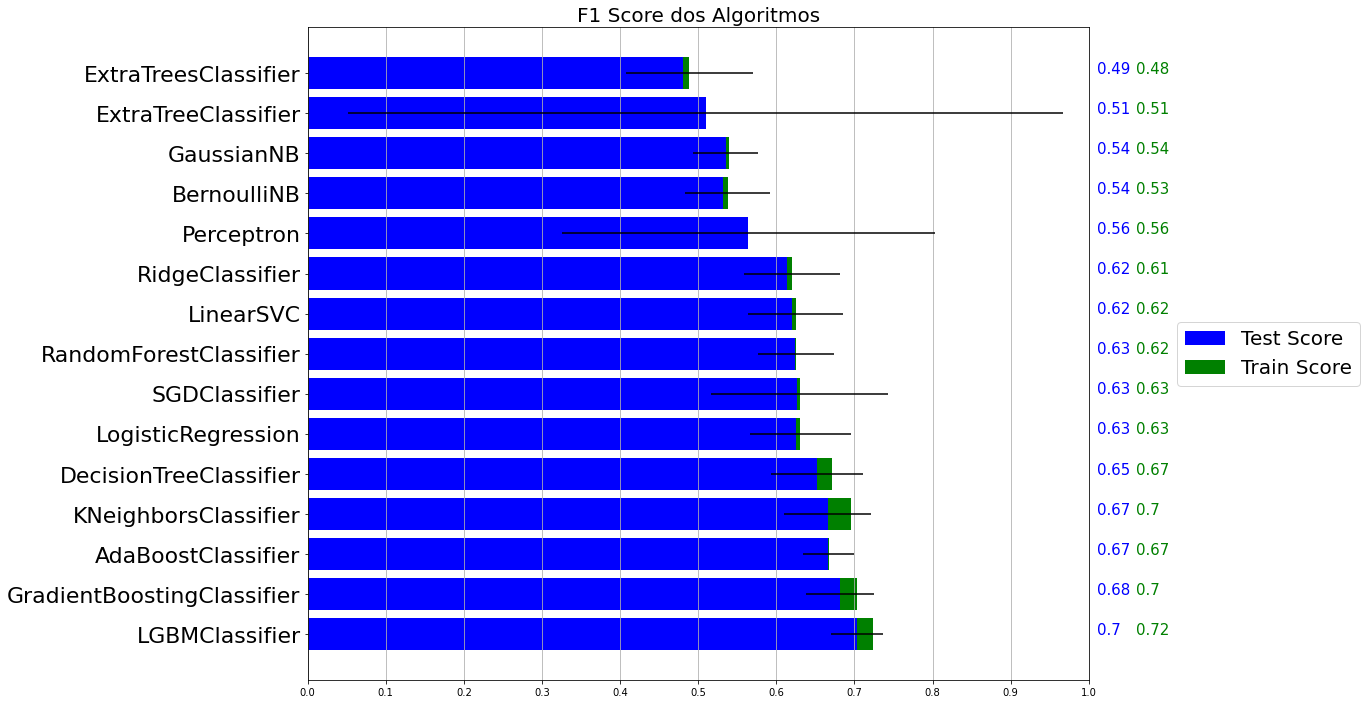

NameError: name 'sda' is not defined

In [39]:
fig, ax = plt.subplots(figsize = (14, 12))
ax.barh(y=MLA_Compare['MLA Name'], width=MLA_Compare['MLA Test F1score Mean'], color = 'b' , label = 'Test Score' , xerr = MLA_Compare['MLA Test F1score DV Pad'] )
ax.barh(y=MLA_Compare['MLA Name'], width=MLA_Compare['MLA Train F1score Mean']- MLA_Compare['MLA Test F1score Mean'], color = 'g', label = "Train Score", left=MLA_Compare['MLA Test F1score Mean'] )
for index, data in enumerate(MLA_Compare['MLA Test F1score Mean']):
    plt.text(x=1.01 , y = index, s=MLA_Compare['MLA Test F1score Mean'][index].round(2) ,color = "b", fontsize=15)
    plt.text(x=1.06 , y = index, s=MLA_Compare['MLA Train F1score Mean'][index].round(2), color = "g", fontsize=15)
plt.xlim(0,1)
ax.grid(axis="x")
plt.yticks(fontsize= 22)
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title('F1 Score dos Algoritmos', fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=20)
plt.show()

## Separando a variável resposta e dividindo entre treino e teste
Será utilizado 25% dos dados para teste e 75% para treino.  
Anteriormente havia utilizado como métrica para avaliação do algoritmo o ROC AUC Score o algoritmo LGBM foi performou de maneira semelhante sendo o que melhorou se adequou aos dados, porém resolvi alterar para o F1 Score em função de justamente levar em consideração a Precisão e o Recall do Algoritmo. Neste algoritmo o meu próposito é obter um Recall alto que no caso seria captar o maximo de pessoas que não irão realizar vendas não deixando de lado de o modelo ser preciso na sua decisão.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], stratify= df[target], random_state= 123)

### Função para plotar os gráficos

In [14]:
def plot_f1_recxprec(labels , resultados1, resultados2):
    # Plotando o Gráfico 
    #Grafico 1 - F1 Score / Gráfico 2 - Precision e Recall Score
    fig1, (ax1,ax2) = plt.subplots(ncols=1, nrows=2, figsize = (8,10))
    largura = 0.5

    ##################################################
    ############### Gráfico 1 F1 Score ###############
    ##################################################

    pox_x = [0.25, 0.75]
    f1_train = ax1.bar(x = 0.25, height = resultados1['Não Vendeu']['f1-score'], width = largura/2, color= "b")
    f1_teste = ax1.bar(x = 0.75, height = resultados2['Não Vendeu']['f1-score'], width = largura/2, label = "F1 Score", color= "green")

    #Configuraçao do gráfico 1
    ax1.set_title('F1 Score')
    #Eixo Y
    ax1.set_yticks(np.arange(0,1.1,0.1))
    ax1.set_ylabel('Score')
    #Eixo X
    ax1.set_xticks(pox_x)
    ax1.set_xticklabels(labels)
    #Outras Configurações
    ax1.bar_label(f1_train, padding=3, fmt = '%.2f')
    ax1.bar_label(f1_teste, padding=3, fmt = '%.2f')

    ##################################################
    ########## Gráfico 2 Precision e Recall ##########
    ##################################################

    pox_x = [0, 1]
    prec_train = ax2.bar(x = - largura/4 - 0.01, height = resultados1['Não Vendeu']['precision'], width = largura/2, color= "slateblue")
    recall_train = ax2.bar(x = largura/4 + 0.01, height = resultados1['Não Vendeu']['recall'], width = largura/2, color="coral")
    prec_teste = ax2.bar(x = 1 - largura/4 - 0.01, height = resultados2['Não Vendeu']['precision'], width = largura/2, label = "Precision Score", color= "slateblue")
    recall_teste = ax2.bar(x = 1+ largura/4 + 0.01, height = resultados2['Não Vendeu']['recall'], width = largura/2, label = "Recall Score", color="coral")

    #Configuraçao do gráfico 2
    ax2.set_title(f'Precision e Recall Score {labels[0]} e {labels[1]}')
    #Eixo Y
    ax2.set_ylabel('Score')
    ax2.set_yticks(np.arange(0,1.1,0.1))
    #Eixo X
    ax2.set_xticks(pox_x)
    ax2.set_xticklabels(labels)
    #Outras Configurações
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 12)
    ax2.bar_label(prec_train, padding=3, fmt = '%.2f')
    ax2.bar_label(recall_train, padding=3, fmt = '%.2f')
    ax2.bar_label(prec_teste, padding=3, fmt = '%.2f')
    ax2.bar_label(recall_teste, padding=3, fmt = '%.2f')


    plt.show()

##  LGBM - *Light Gradient Boosting Model*
Como o LGBM possui um próprio meio de lidar com Variáveis Categóricas retirei da Pipeline o One Hot Encoder.  
Existe uma variação grande ao observar os resultados no dataset de Treino e Teste, na etapa seguinte de Hiperparametrização deve-se tomar cuidado com o overfit nos dados de Treino.


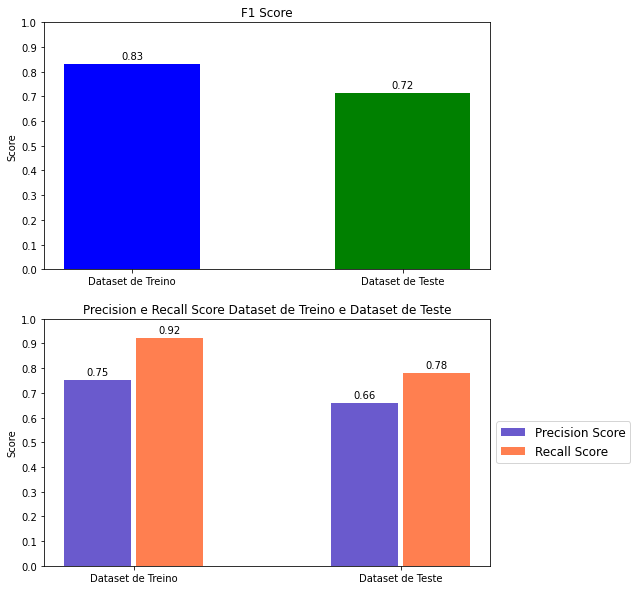

In [15]:
#Elaboração do Pipeline
preparation1 = ColumnTransformer( transformers=  [  ('numeric', num_enc, num_features)])
pipe_lgbm = Pipeline([  ('prep' , preparation1),
                        ('alg' , lgb.LGBMClassifier(is_unbalance =  True))])

#Realizando o fit aos dados de Treino
pipe_lgbm.fit(X_train, y_train)

# Prevendo os valores para o dataset de Treino e Teste
y_train_pred = pipe_lgbm.predict(X_train)
y_teste_pred = pipe_lgbm.predict(X_test)

#Carregando os scores
resultados_train = classification_report(y_train, y_train_pred, target_names=["Vendeu", "Não Vendeu"], output_dict=True)
resultados_teste = classification_report(y_test, y_teste_pred, target_names=["Vendeu", "Não Vendeu"], output_dict=True)

#Plotando os resultados
plot_f1_recxprec(labels=["Dataset de Treino", "Dataset de Teste"], resultados1= resultados_train, resultados2=resultados_teste)


## Otimizacão dos Hyperparametros


###  LGBM - *Light Gradient Boosting Model*

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   16.1s finished


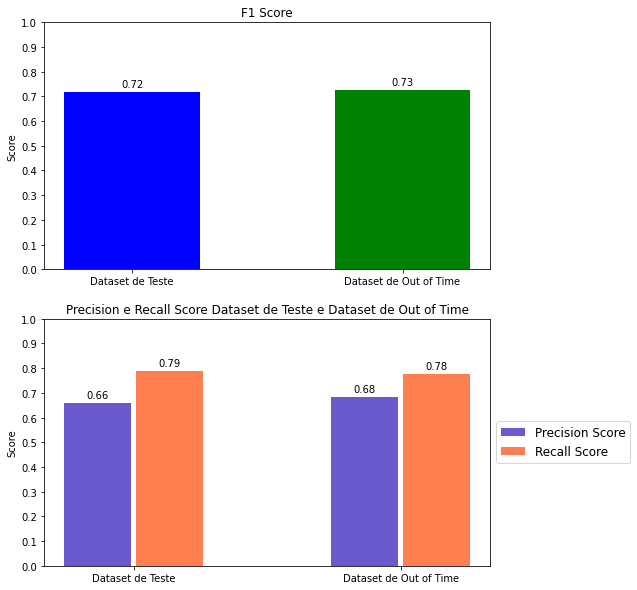

In [16]:
grid_lgbm = {   
                'alg__boosting_type' : ['gbdt'], 
                'alg__colsample_bytree' : [0.65],
                'alg__learning_rate': [0.05], # ja foi otimizado junto ao n_estimatores
                'alg__max_bin' : [300], #Não apresentou melhoria com maior numero
                'alg__n_estimators' : [750], # ja foi otimizado junto ao learning rate
                'alg__num_leaves': [10], # para evitar o overfit dos dados
                'alg__objective' : ['binary'],
                'alg__reg_alpha' : [0.5, 0.65, 0.75],
                'alg__reg_lambda' : [0.5, 0.6, 0.7],
                'alg__subsample' : [0.65]
            }

#optm_lgbm = RandomizedSearchCV(     estimator=pipe_lgbm, param_distributions=grid_lgbm, 
#                                    n_iter=300, n_jobs=-1, cv = cv_split, 
#                                    scoring='f1', verbose=1,
#                                    random_state=123)

grid_sc_lgbm = GridSearchCV(estimator=pipe_lgbm, param_grid=grid_lgbm, n_jobs=-1, cv=cv_split, scoring='f1', verbose=1 , return_train_score=True)

grid_sc_lgbm.fit(X_train[features], y_train)

resultados_lgbm = pd.DataFrame(grid_sc_lgbm.cv_results_)
resultados_lgbm.sort_values(by='rank_test_score', ascending= True, inplace=True)

pipe_lgbm.set_params(**grid_sc_lgbm.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

# Prevendo os valores para o dataset de Treino e Teste
y_test_pred_opt = pipe_lgbm.predict(X_test)
y_oot_pred = pipe_lgbm.predict(df_oot[features])

# Score dos valores para o dataset de Treino e Teste
y_test_proba = pipe_lgbm.predict_proba(X_test)[:,1]
y_oot_proba = pipe_lgbm.predict_proba(df_oot[features])[:,1]


#Carregando os scores
resultados_train_opt = classification_report(y_test, y_test_pred_opt, target_names=["Vendeu", "Não Vendeu"], output_dict=True)
resultados_oot = classification_report(df_oot[target], y_oot_pred, target_names=["Vendeu", "Não Vendeu"], output_dict=True)


#Plotando os resultados
plot_f1_recxprec(labels=["Dataset de Teste", "Dataset de Out of Time"], resultados1= resultados_train_opt, resultados2=resultados_oot)


## Análise dos resultados no Dataset Out of Time

Com os Resultados obtidos nos Algoritmos e com base nas probabilidades da variável ser 1 ou 0 plotei apenas para ter uma ideia de como estaria a Distribuição dos dados 

| Intervalo entre os scores &nbsp; &nbsp;| Ações |
|:----------: | :------------- | 
| **<font color="red">1 e 0,81</font>** | Possuem uma grande chance de não realizarem vendas e podem ser ofertadas soluções que requeiram um investimento maior como: uma consultoria personalizada, desconto na comissão das vendas, meses grátis na plataforma.|
|**<font color="orange">0,8 e 0,61</font>** | Para este grupo de vendedores podem ser aplicados outras campanhas de retenção que não exijam tanto investimento quanto ao grupo anterior: envio de e-mails com melhores práticas para vendas, aumentar a relevância e o alcance, aumentar a variedades de produtos na plataforma afim de melhorar as vendas.|
|**<font color="yellow">0,6 e 0,3</font>** | Estes vendedores ainda podem representar um potencial risco de não realizar vendas portanto campanhas de e-mails contendo as tendências de vendas atuais e outras análises podem aumentar ainda mais as chances de vendas.|
|**<font color="blue">0,3 e 0</font>** | Representam clientes que potencialmente vão realizar vendas e que não serão foco para este case.|

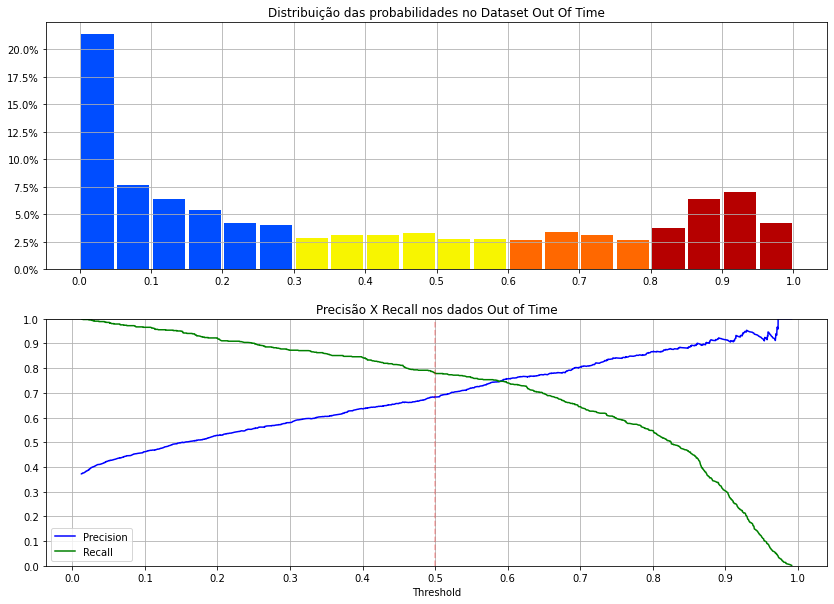

In [17]:
#Carregando os valores de precision e Recall do dataset OOT
precisions , recalls , thresh = precision_recall_curve(df_oot[target],y_oot_proba)

fig2 , (ax1,ax2) = plt.subplots(ncols=1, nrows=2, figsize = (14,10))

##################################################
############## Gráfico 1 Histograma ##############
##################################################
ax1.grid()

#Configuraçao do gráfico
ax1.set_title('Distribuição das probabilidades no Dataset Out Of Time')
bin_edges = np.arange(0,1.01, step=0.05)
#Plot
n, bins, patches  = ax1.hist(y_oot_proba, bins=bin_edges, rwidth=0.9, weights=np.ones(len(y_oot_proba)) / len(y_oot_proba) )
#Eixo X
ax1.set_xticks(np.arange(0,1.1,0.1))
ax1.yaxis.set_major_formatter(PercentFormatter(1))

#Ajustando as cores
cmap = plt.get_cmap('jet')
very_low = cmap(0.2)
low = cmap(0.65)
high = cmap(0.8)
very_high = cmap(0.95)
for i in range(0,6):
    patches[i].set_facecolor(very_low)
for i in range(6,16):
    patches[i].set_facecolor(low)
for i in range(12,16):
    patches[i].set_facecolor(high)
for i in range(16,20):
    patches[i].set_facecolor(very_high)

##################################################
######## Gráfico 2 Precision X Recall ############
##################################################

#Configuraçao do gráfico
ax2.set_title("Precisão X Recall nos dados Out of Time")
#Plot
ax2.plot(thresh, precisions[:-1], 'b', label = "Precision")
ax2.plot(thresh, recalls[:-1], 'g', label = "Recall")
ax2.axvline(x=0.5,ymin=0, ymax=1, alpha = 0.3, color= 'red', ls= "--")
#Eixo X
ax2.set_xlabel("Threshold")
ax2.set_xticks(np.arange(0, 1.1, step=0.1))
#Eixo Y
ax2.set_ylim([0,1])
ax2.set_yticks(np.arange(0, 1.1, step=0.1))

#Outras Configurações
ax2.grid()
ax2.legend()

plt.show()

## Salvando um Pickle com as informaçoes relavantes

In [18]:
# Preparando para o arquivo Pickle
prec_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_opt )
prec_oot, recall_oot, _ = precision_recall_curve(df_oot[target],y_oot_proba)
auc_test = auc(recall_test, prec_test)
auc_oot = auc(recall_oot, prec_oot)

pick = {    "cols_num" : num_features,
            "cat_features" : cat_features,
            "features" : features,
            "target" : target,
            "grid_parametres" : grid_lgbm,
            "pipeline_algoritmo" : grid_sc_lgbm.best_estimator_,
            "auc_score_test" : auc_test,
            "auc_score_oot" : auc_oot}

historical = pd.Series(pick)
print("Arquivo Pickle Criado")
historical.to_pickle(os.path.join(dir_project, 'Modelling/modelo_otimizado.pkl'))

Arquivo Pickle Criado
